#Mini-Projet ML Supervisée

##Importation des librairies

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import os
import sklearn
import xgboost
print(f"scikit-learn=={sklearn.__version__}")
print(f"xgboost=={xgboost.__version__}")

scikit-learn==1.6.1
xgboost==3.2.0


##Importation du dataset depuis Kaggle

Le dataset parle de maintenance prédictive dans un environnement industriel.

Il s’agit d’un jeu de données synthétique IoT industriel contenant 24 042 enregistrements provenant de 20 machines différentes.

In [3]:
#Chemin vers le dataset
dataset_path = kagglehub.dataset_download(
    "tatheerabbas/industrial-machine-predictive-maintenance"
)

100%|██████████| 550k/550k [00:00<00:00, 687kB/s]

Extracting files...


In [4]:
#Chemin complet
file_path = os.path.join(dataset_path, "predictive_maintenance_v3.csv")
#Chargement des données dans un dataframe
df = pd.read_csv(file_path)

##Analyse Exploratoire des données

In [5]:
df.head()

,timestamp,machine_id,machine_type,vibration_rms,temperature_motor,current_phase_avg,pressure_level,rpm,operating_mode,hours_since_maintenance,ambient_temp,rul_hours,failure_within_24h,failure_type,estimated_repair_cost
0,2024-01-01 00:00:00,1,CNC,0.81,49.51,5.10,23.6,860.9,idle,273.80,13.9,61.00,0,none,0
1,2024-01-01 00:03:00,1,CNC,0.75,40.58,5.30,23.6,899.6,idle,273.85,10.2,60.95,0,none,0
2,2024-01-01 00:21:00,1,CNC,0.71,49.70,NaN,21.3,862.7,idle,274.15,13.6,60.65,0,none,0
3,2024-01-01 00:45:00,1,CNC,0.76,43.04,4.79,22.6,870.4,idle,274.55,13.4,60.25,0,none,0
4,2024-01-01 00:54:00,1,CNC,0.88,41.39,4.44,22.2,881.9,idle,274.70,10.8,60.10,0,none,0


In [6]:
# Résumé statistique des colonnes numériques
df.describe()

,machine_id,vibration_rms,temperature_motor,current_phase_avg,pressure_level,rpm,hours_since_maintenance,ambient_temp,rul_hours,failure_within_24h,estimated_repair_cost
count,24042.000000,23042.000000,23208.000000,23311.000000,23118.000000,23509.000000,24042.000000,24042.000000,24042.000000,24042.000000,24042.000000
mean,10.505033,1.623667,51.404295,8.823829,59.012233,1144.849317,172.630624,12.996398,27.812510,0.148074,608.870144
std,5.746455,1.081061,12.519279,5.366391,38.723271,912.670971,150.722469,2.883994,26.393801,0.355181,1566.793887
min,1.000000,0.350000,28.000000,2.200000,10.100000,124.100000,0.000000,8.000000,0.500000,0.000000,0.000000
25%,6.000000,0.820000,42.610000,4.630000,22.700000,489.400000,42.870000,10.500000,0.500000,0.000000,0.000000
50%,10.000000,1.270000,50.060000,6.430000,46.300000,856.000000,121.610000,13.000000,22.570000,0.000000,0.000000
75%,15.000000,2.270000,59.962500,13.120000,94.700000,1676.000000,295.575000,15.500000,46.410000,0.000000,0.000000
max,20.000000,10.000000,95.000000,35.000000,206.500000,4098.800000,575.630000,18.000000,98.340000,1.000000,7995.000000


On remarque que les échelles de valeurs entre les colonnes sont très différentes, on pourra donc penser à normaliser les colonnes afin de tout réduire et mettre à la même échelle.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24042 entries, 0 to 24041
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                24042 non-null  object 
 1   machine_id               24042 non-null  int64  
 2   machine_type             24042 non-null  object 
 3   vibration_rms            23042 non-null  float64
 4   temperature_motor        23208 non-null  float64
 5   current_phase_avg        23311 non-null  float64
 6   pressure_level           23118 non-null  float64
 7   rpm                      23509 non-null  float64
 8   operating_mode           24042 non-null  object 
 9   hours_since_maintenance  24042 non-null  float64
 10  ambient_temp             24042 non-null  float64
 11  rul_hours                24042 non-null  float64
 12  failure_within_24h       24042 non-null  int64  
 13  failure_type             24042 non-null  object 
 14  estimated_repair_cost 

On remarque grâce à la fonction .info() que nous avons des colonnes de type int, float et string. Nous voyons aussi que certaines colonnes ont des valeurs nulles. Nous allons nous intéressé aux valeurs nulles après avoir supprimé les colonnes qui ne nous intéressaient pas.

In [8]:
# Liste des colonnes à supprimer car elles ne sont pas utiles

cols_to_drop = [
    "timestamp",
    "machine_id",
    "machine_type",
    "current_phase_avg",
    "hours_since_maintenance",
    "ambient_temp",
    "estimated_repair_cost"
]

df_clean = df.drop(columns=cols_to_drop, errors="ignore")




###Présence de valeur null

In [9]:
null_percentage = df_clean.isnull().mean() * 100
null_percentage = null_percentage.sort_values(ascending=False)
print("Pourcentage des valeurs nulls par colonnes :")
print(" ")
print(null_percentage)

Pourcentage des valeurs nulls par colonnes :
 
vibration_rms         4.159388
pressure_level        3.843274
temperature_motor     3.468929
rpm                   2.216954
operating_mode        0.000000
rul_hours             0.000000
failure_within_24h    0.000000
failure_type          0.000000
dtype: float64


La présence de valeur null dans nos colonnes n'est pas très importante (donc pas très génant pour nos analyses). Nous pouvons donc les supprimer ou bien les remplacer par la valeur moyenne présente dans nos colonnes.

###Détéction d'outlier

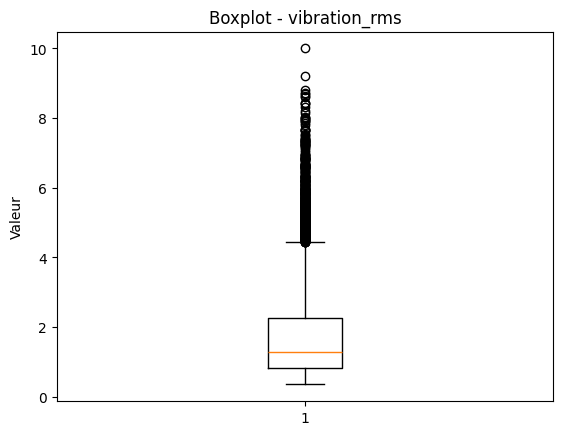

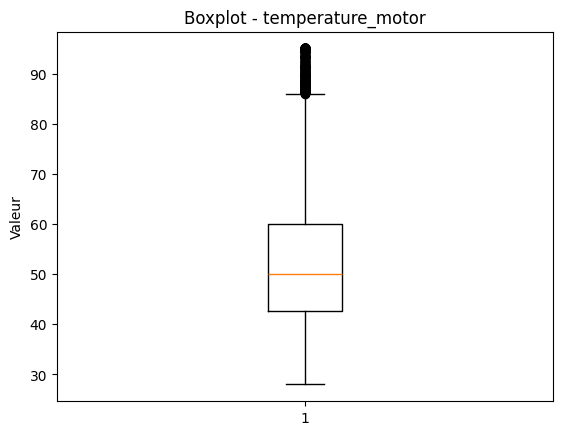

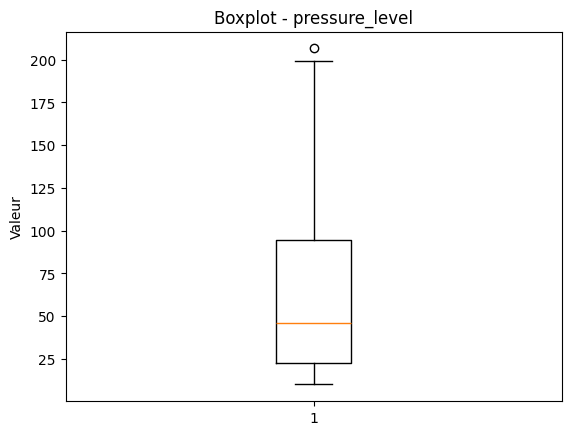

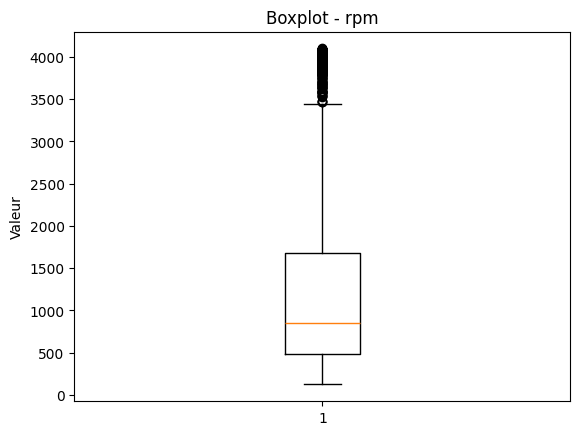

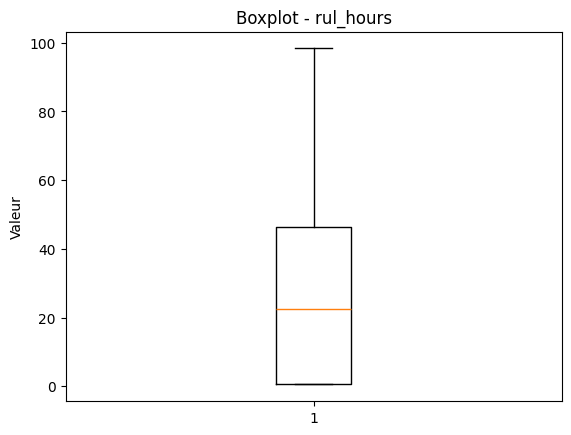

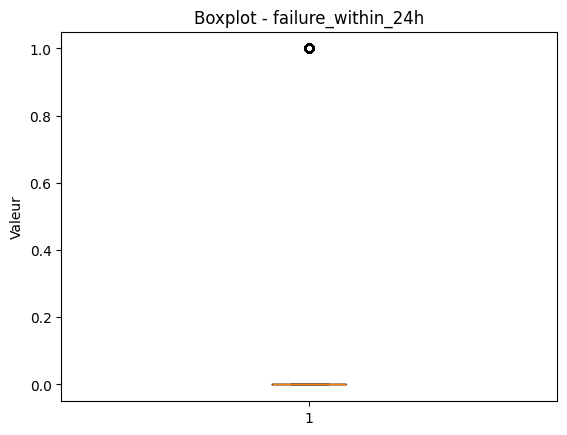

In [10]:
df_numeric = df_clean.select_dtypes(include="number")

for col in df_numeric.columns:
    plt.figure()
    plt.boxplot(df_numeric[col].dropna())
    plt.title(f"Boxplot - {col}")
    plt.ylabel("Valeur")
    plt.show()


Nous remarquons que nos données ne contiennent pas de valeur abérrante, seulement des valeurs élevées pour certaines colonnes (comme la vibration_rms) mais qui sont intéressantes de garder dans le contexte de la maintenance prédictive.
Cependant, nous les supprimerons peut-être si le modèle accorde trop d'importance aux valeurs élevées.

###Matricle de corrélation

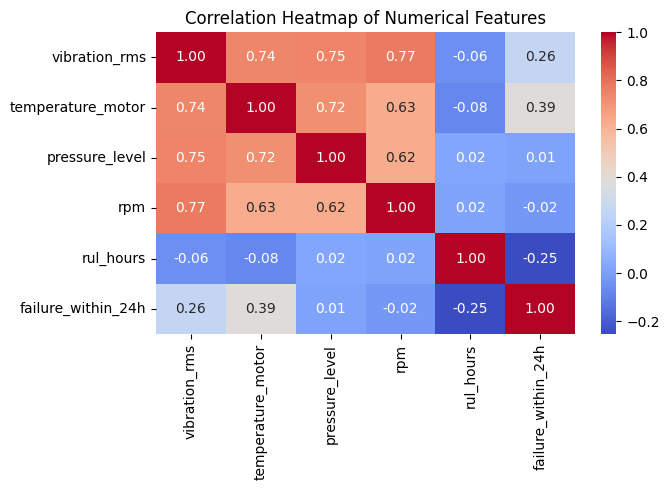

In [11]:
numerical_data = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(7, 5))
sns.heatmap(
    numerical_data.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


La matrice de corrélation montre que les variables capteurs (vibration, température moteur, pression et RPM) sont fortement corrélées entre elles, avec des coefficients compris entre 0.62 et 0.77, ce qui signifie qu’elles évoluent globalement dans le même sens lorsque la machine change d’état de fonctionnement.

### Distribution des données

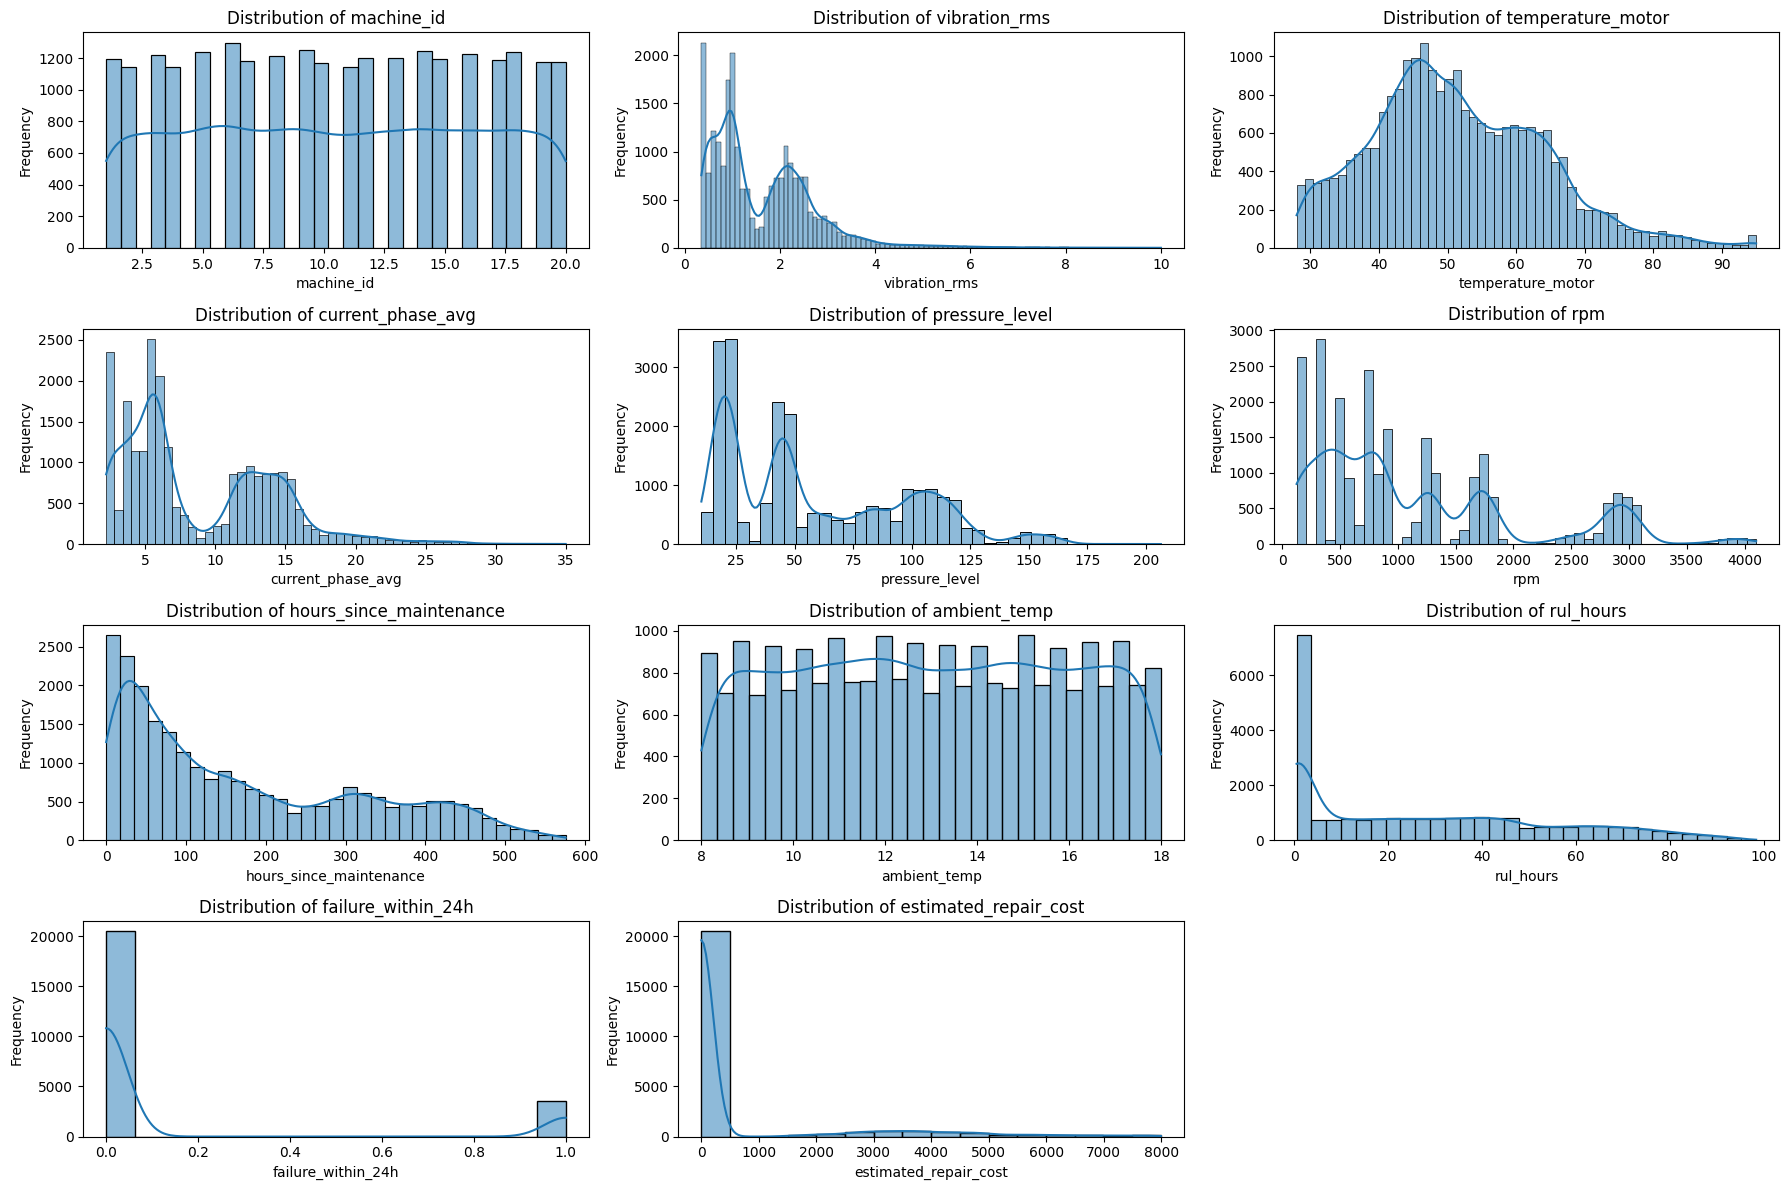

In [12]:
# Sélection des colonnes numériques
numerical_data = df.select_dtypes(include=[np.number])

num_cols = len(numerical_data.columns)
num_rows = (num_cols + 2) // 3  # 3 colonnes par ligne

plt.figure(figsize=(18, num_rows * 3))

for i, column in enumerate(numerical_data.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.histplot(numerical_data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Les distributions montrent que la plupart des variables ne suivent pas une loi normale. On voit aussi que la colonne failre_within_24h est très déséquilibrée, ce qui pourrai poser un problème si l'on souhaite faire une classification avec cette colonne en target.

#Modèle 1 (Baseline) : Régression Logistique (optimisée + Feature Importance).

Début de l'optimisation de la Régression Logistique...

Meilleurs paramètres trouvés : {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}

--- Rapport de Classification (Régression Logistique) ---
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4097
           1       0.58      0.85      0.69       712

    accuracy                           0.89      4809
   macro avg       0.77      0.87      0.81      4809
weighted avg       0.91      0.89      0.89      4809



/tmp/ipython-input-941/1486616060.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance_lr.head(15), palette='viridis')


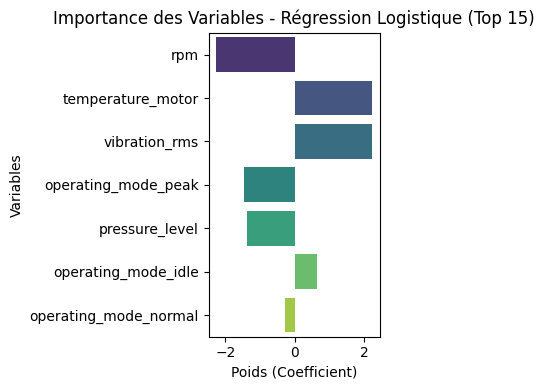

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. PRÉPARATION DES DONNÉES ---
target = 'failure_within_24h'
# On supprime les autres cibles possibles pour éviter les fuites de données (Data Leakage)
columns_to_exclude = [target, 'failure_type', 'rul_hours', 'estimated_repair_cost']
# Assurons-nous que ces colonnes existent avant de les drop
cols_to_drop = [c for c in columns_to_exclude if c in df_clean.columns]

X = df_clean.drop(columns=cols_to_drop)
y = df_clean[target]

# Identification des types de variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Création des transformateurs
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assembleur (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Séparation Train / Test (stratify est crucial car les pannes sont rares)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 2. MODÈLE 1 : RÉGRESSION LOGISTIQUE (BASELINE) ---
# Création du pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Optimisation des hyperparamètres (GridSearch)
# On teste différentes forces de régularisation (C)
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

print("Début de l'optimisation de la Régression Logistique...")
grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='recall', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

best_lr_model = grid_search_lr.best_estimator_

# --- 3. ÉVALUATION ---
print("\nMeilleurs paramètres trouvés :", grid_search_lr.best_params_)
y_pred_lr = best_lr_model.predict(X_test)

print("\n--- Rapport de Classification (Régression Logistique) ---")
print(classification_report(y_test, y_pred_lr))


# --- 4. INTERPRÉTATION : IMPORTANCE DES VARIABLES ---
# Extraction des noms de colonnes après encodage OneHot
cat_encoder = best_lr_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

# Extraction des coefficients du modèle de régression logistique
coefficients = best_lr_model.named_steps['classifier'].coef_[0]

# Création d'un DataFrame pour la visualisation
feature_importance_lr = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Affichage graphique
plt.figure(figsize=(4, 4))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_lr.head(15), palette='viridis')
plt.title("Importance des Variables - Régression Logistique (Top 15)")
plt.xlabel("Poids (Coefficient)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

#Interprétations

##Analyse du Modèle 1 (Régression Logistique Baseline)

**Performance (Le compromis Précision/Recall)** : Ce modèle obtient un Recall de 0.85 pour la détection de pannes (classe 1). C'est très correct pour une "baseline" : il repère 85% des pannes réelles. Cependant, sa Précision n'est que de 0.58. En d'autres termes, quand le modèle déclenche une alerte de panne, il se trompe presque une fois sur deux (fausses alertes). Le F1-score (0.69) reflète ce déséquilibre.


**Facteurs de risque (coefficients positifs)** : La température du moteur (temperature_motor) et les vibrations (vibration_rms) sont les deux signaux les plus alarmants. Si ces valeurs augmentent, la probabilité de panne grimpe en flèche. Cela fait parfaitement sens d'un point de vue mécanique industriel.

**Facteurs de "santé" (coefficients négatifs)** : La vitesse de rotation (rpm) et la pression (pressure_level) ont des poids négatifs élevés. Cela suggère (dans ce dataset spécifique) qu'une baisse de régime ou de pression est peut-être le symptôme d'une anomalie.

# Modèle 2 (Random Forest Optimisé)
Maintenant, nous allons passer à un modèle ensembliste : le Random Forest. Contrairement à la régression logistique, il peut capturer des relations non-linéaires complexes (par exemple, une vibration critique uniquement si la température est aussi élevée).

Pour gagner du temps sans sacrifier la qualité, nous allons utiliser RandomizedSearchCV au lieu de GridSearchCV pour l'optimisation.

Ajoute ce code dans une nouvelle cellule (il réutilise le preprocessor et les variables X_train, y_train que tu as déjà créés) :

Début de l'optimisation du Random Forest (cela peut prendre 1 à 2 minutes)...

Meilleurs paramètres RF : {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__max_depth': 10}

--- Rapport de Classification (Random Forest Optimisé) ---
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4097
           1       0.71      0.92      0.80       712

    accuracy                           0.93      4809
   macro avg       0.85      0.93      0.88      4809
weighted avg       0.94      0.93      0.94      4809



/tmp/ipython-input-941/1451805064.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_df.head(15), palette='mako')


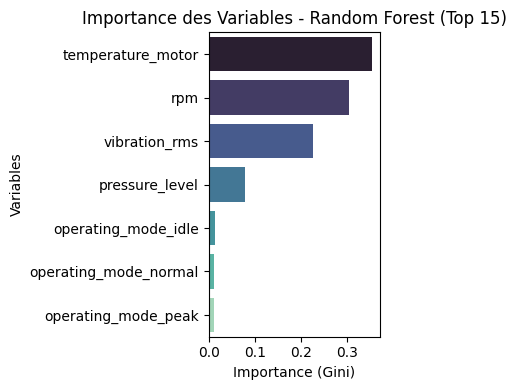

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# --- 1. MODÈLE 2 : RANDOM FOREST OPTIMISÉ ---
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # On garde exactement le même prétraitement !
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Grille d'hyperparamètres à tester
param_dist_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10]
}

print("Début de l'optimisation du Random Forest (cela peut prendre 1 à 2 minutes)...")
random_search_rf = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist_rf,
                                      n_iter=10, cv=5, scoring='recall', random_state=42, n_jobs=-1)

random_search_rf.fit(X_train, y_train)
best_rf_model = random_search_rf.best_estimator_

# --- 2. ÉVALUATION ---
print("\nMeilleurs paramètres RF :", random_search_rf.best_params_)
y_pred_rf = best_rf_model.predict(X_test)

print("\n--- Rapport de Classification (Random Forest Optimisé) ---")
print(classification_report(y_test, y_pred_rf))

# --- 3. INTERPRÉTATION : IMPORTANCE DES VARIABLES ---
# Le Random Forest utilise "feature_importances_" au lieu de coefficients
importances_rf = best_rf_model.named_steps['classifier'].feature_importances_

feature_importance_rf_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

# Affichage graphique
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_df.head(15), palette='mako')
plt.title("Importance des Variables - Random Forest (Top 15)")
plt.xlabel("Importance (Gini)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

#Analyse Comparative : LogReg vs Random Forest Optimisé
1. Le bond des performances (Le Compromis Parfait)

Ton Random Forest optimisé atteint un Recall de 0.92 (contre 0.85 pour la LogReg). Il détecte désormais 92% des pannes !

La magie opère sur la Précision : elle monte à 0.71 (contre 0.58 pour la LogReg). Cela veut dire que les fausses alertes ont drastiquement diminué. Le modèle a appris à faire la différence entre une vraie anomalie et un simple "bruit" passager. Le F1-Score global passe ainsi de 0.69 à 0.80.

2. Différence d'Interprétation des Variables (Les Graphiques)
Les deux graphiques que tu as générés sont très instructifs pour ta soutenance :

Régression Logistique (Poids / Coefficients) : Elle te donne un sens (positif = danger, négatif = rassurant). On y voit que la température augmente le risque, tandis qu'un RPM élevé semble le réduire.

Random Forest (Importance Gini) : Il ne donne pas de sens, mais une force absolue. On voit que la temperature_motor et le rpm sont les deux piliers absolus de l'arbre de décision. Le modèle crée des "règles" complexes croisant ces deux capteurs pour isoler les pannes.

# Modèle 3 (XGBoost)
Pour notre 3ème modèle, nous allons sortir l'artillerie lourde. Le Gradient Boosting (et son implémentation la plus célèbre, XGBoost) est le modèle qui gagne le plus de compétitions sur des données tabulaires (Kaggle).
Contrairement au Random Forest qui crée des arbres indépendants, XGBoost crée des arbres séquentiellement, où chaque nouvel arbre tente de corriger les erreurs du précédent.

Début de l'optimisation de XGBoost...

Meilleurs paramètres XGBoost : {'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}

--- Rapport de Classification (XGBoost) ---
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4097
           1       0.69      0.95      0.80       712

    accuracy                           0.93      4809
   macro avg       0.84      0.94      0.88      4809
weighted avg       0.95      0.93      0.93      4809



/tmp/ipython-input-941/970972251.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb_df.head(15), palette='flare')


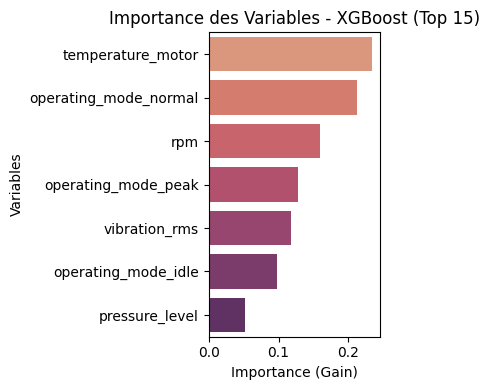

In [15]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# --- 1. MODÈLE 3 : XGBOOST OPTIMISÉ ---
# XGBoost utilise "scale_pos_weight" pour gérer le déséquilibre des classes au lieu de "class_weight"
ratio_desequilibre = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Toujours le même preprocessor !
    ('classifier', xgb.XGBClassifier(scale_pos_weight=ratio_desequilibre,
                                     random_state=42,
                                     eval_metric='logloss'))
])

# Grille d'hyperparamètres (le learning_rate est crucial ici)
param_dist_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7], # Des arbres moins profonds qu'un Random Forest
    'classifier__learning_rate': [0.01, 0.05, 0.1]
}

print("Début de l'optimisation de XGBoost...")
random_search_xgb = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist_xgb,
                                       n_iter=10, cv=5, scoring='recall', random_state=42, n_jobs=-1)

random_search_xgb.fit(X_train, y_train)
best_xgb_model = random_search_xgb.best_estimator_

# --- 2. ÉVALUATION ---
print("\nMeilleurs paramètres XGBoost :", random_search_xgb.best_params_)
y_pred_xgb = best_xgb_model.predict(X_test)

print("\n--- Rapport de Classification (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb))

# --- 3. INTERPRÉTATION : IMPORTANCE DES VARIABLES ---
importances_xgb = best_xgb_model.named_steps['classifier'].feature_importances_

feature_importance_xgb_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

# Affichage graphique
plt.figure(figsize=(4, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb_df.head(15), palette='flare')
plt.title("Importance des Variables - XGBoost (Top 15)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

Analyse : Le triomphe de XGBoost
1. Le score parfait pour l'industrie (Recall de 0.95)

Le modèle XGBoost a pulvérisé le score de détection, atteignant un Recall de 0.95. Cela signifie qu'il détecte 95% des pannes avant qu'elles ne se produisent !

En contrepartie, la précision baisse très légèrement (0.69 contre 0.71 pour le Random Forest). C'est le compromis classique : le modèle est plus "paranoïaque" et génère un peu plus de fausses alertes pour s'assurer de ne rater aucune vraie panne. Dans 99% des cas en maintenance industrielle, c'est exactement ce que l'on recherche.

2. Une vision différente des variables (Le Gain)

Contrairement au Random Forest qui compte les variables les plus fréquemment utilisées, XGBoost utilise le Gain (l'amélioration de la pureté apportée par une variable).

La temperature_motor reste la reine incontestée, mais XGBoost a découvert que l'operating_mode_normal (le fait que la machine soit censée être en mode normal ou non) est un critère de séparation massif pour prédire une défaillance.

🏗️ Brique 4 : Le Deep Learning (MLP) & l'explicabilité SHAP
Le cahier des charges impose l'intégration d'un réseau de neurones multicouches (MLP). L'objectif est de vérifier si le Deep Learning peut faire encore mieux que XGBoost (spoiler : sur des données tabulaires de cette taille, c'est rare, mais il faut le prouver scientifiquement !).

Nous allons également intégrer la bibliothèque SHAP, qui est la norme de l'industrie pour expliquer les "boîtes noires" comme le Deep Learning (EF3).

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.utils.class_weight import compute_class_weight
import scipy.sparse

# Préparation spécifique pour le Deep Learning
X_train_dl = preprocessor.fit_transform(X_train)
X_test_dl = preprocessor.transform(X_test)

if scipy.sparse.issparse(X_train_dl):
    X_train_dl = X_train_dl.toarray()
    X_test_dl = X_test_dl.toarray()

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
input_dim = X_train_dl.shape[1]

# --- 1. ARCHITECTURE AVANCÉE (MLP 2.0) ---
mlp_advanced = models.Sequential([
    # Couche 1
    layers.Dense(128, input_shape=(input_dim,)),
    layers.BatchNormalization(), # Normalisation interne (très puissant)
    layers.Activation('relu'),
    layers.Dropout(0.4),

    # Couche 2
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    # Couche 3
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Couche 4
    layers.Dense(16),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Sortie
    layers.Dense(1, activation='sigmoid')
])

mlp_advanced.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='recall')])

# --- 2. CALLBACKS EXPERTS ---
# Early Stopping surveille toujours la perte de validation avec une patience un peu plus longue
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau : Divise le learning rate par 5 si la val_loss stagne pendant 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

print("Entraînement du MLP 2.0 en cours (avec ajustement dynamique du Learning Rate)...")
history_adv = mlp_advanced.fit(
    X_train_dl, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# --- 3. ÉVALUATION FINALE ---
loss, recall_adv = mlp_advanced.evaluate(X_test_dl, y_test, verbose=0)

# Optionnel : Ajuster le seuil de décision (Threshold)
# Au lieu de dire "Panne si probabilité > 50%", on peut dire "Panne si probabilité > 40%"
y_pred_probs = mlp_advanced.predict(X_test_dl, verbose=0)
seuil = 0.4
y_pred_custom = (y_pred_probs > seuil).astype(int)

from sklearn.metrics import recall_score, precision_score
recall_custom = recall_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)

print(f"\n--- Performance MLP 2.0 (Deep Learning) ---")
print(f"Recall (Seuil 0.5 standard) : {recall_adv:.2f}")
print(f"Recall (Seuil ajusté à 0.4) : {recall_custom:.2f} (Précision : {precision_custom:.2f})")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entraînement du MLP 2.0 en cours (avec ajustement dynamique du Learning Rate)...

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-06.

--- Performance MLP 2.0 (Deep Learning) ---
Recall (Seuil 0.5 standard) : 0.92
Recall (Seuil ajusté à 0.4) : 0.94 (Précision : 0.55)


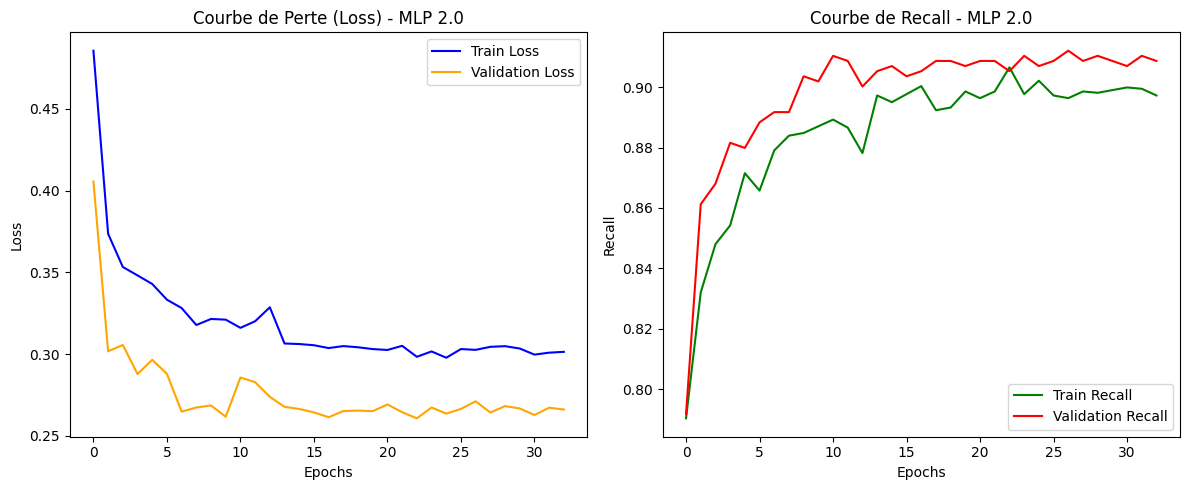


Calcul des valeurs SHAP avec KernelExplainer pour le MLP 2.0 (patientez quelques secondes)...


  0%|          | 0/50 [00:00<?, ?it/s]

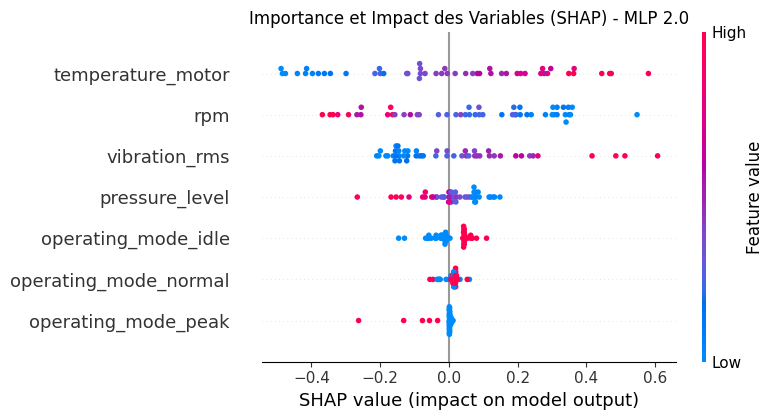

In [17]:
import matplotlib.pyplot as plt
import shap

# --- 1. COURBES D'APPRENTISSAGE (Loss et Recall) ---
plt.figure(figsize=(12, 5))

# Courbe de la perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'], label='Train Loss', color='blue')
plt.plot(history_adv.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Courbe de Perte (Loss) - MLP 2.0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe du Recall
plt.subplot(1, 2, 2)
plt.plot(history_adv.history['recall'], label='Train Recall', color='green')
plt.plot(history_adv.history['val_recall'], label='Validation Recall', color='red')
plt.title('Courbe de Recall - MLP 2.0')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# --- 2. INTERPRÉTABILITÉ (SHAP Kernel pour MLP 2.0) ---
print("\nCalcul des valeurs SHAP avec KernelExplainer pour le MLP 2.0 (patientez quelques secondes)...")

# Fonction d'encapsulation pour le MLP 2.0
def model_predict_adv(data):
    return mlp_advanced.predict(data, verbose=0).flatten()

# Résumé des données pour accélérer KernelExplainer
background_summary_adv = shap.kmeans(X_train_dl[:500], 10)

explainer_kernel_adv = shap.KernelExplainer(model_predict_adv, background_summary_adv)

# Calcul sur un échantillon pour obtenir le graphe rapidement
shap_values_kernel_adv = explainer_kernel_adv.shap_values(X_test_dl[:50])

# Affichage du graphe
plt.figure(figsize=(10, 6))
plt.title("Importance et Impact des Variables (SHAP) - MLP 2.0")
shap.summary_plot(shap_values_kernel_adv, X_test_dl[:50], feature_names=all_feature_names)

1. Analyse des Courbes d'Apprentissage (MLP 2.0)
La preuve de stabilité : Regarde ta courbe de Loss (à gauche). La courbe orange (Validation) descend, ondule un peu (c'est l'effet du ReduceLROnPlateau qui ajuste le tir), puis se stabilise autour de 0.27 sans jamais remonter en flèche. Tu as prouvé visuellement que ton modèle ne fait pas d'overfitting.

Le plafond de verre du DL : Sur la courbe de droite, on voit que le Recall de validation plafonne autour de 0.90. Malgré une architecture complexe, la Batch Normalization et un apprentissage dynamique, le réseau de neurones n'arrive pas à battre la logique implacable des arbres de décision de ton XGBoost (qui, rappelons-le, est à 0.95).

🎯 2. Lecture du Graphique SHAP (L'Explicabilité)
Ce graphique est magique car il explique la "boîte noire" à un responsable maintenance :

L'axe horizontal représente l'impact sur la prédiction (vers la droite = danger de panne, vers la gauche = machine saine).

La couleur représente la valeur du capteur (Rouge = valeur très élevée, Bleu = valeur très basse).

Exemple concret à citer : Regarde la ligne temperature_motor. Les points rouges (température élevée) sont tous poussés vers la droite. Conclusion : Une surchauffe provoque presque systématiquement une panne. À l'inverse pour le rpm, les points bleus (vitesse anormalement basse) sont à droite : une perte de vitesse est un signe avant-coureur de défaillance.

# Bilan de la Modélisation


Régression Logistique (Baseline)

Random Forest (Robuste)

XGBoost (Le Grand Champion - Recall 0.95)

Deep Learning MLP 2.0 (La tentative avancée)

# Le Déploiement Cloud

In [20]:
import joblib

# 1. On sauvegarde le preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

# 2. On extrait et sauvegarde UNIQUEMENT le modèle XGBoost (sans le pipeline)
modele_pur_xgb = best_xgb_model.named_steps['classifier']
joblib.dump(modele_pur_xgb, 'xgboost_model.joblib')

print("Fichiers sauvegardés avec succès ! Prêts pour Streamlit.")

Fichiers sauvegardés avec succès ! Prêts pour Streamlit.


Lien vers le dashboard : https://maintenance-predictive-dashboard-cdzrrouxwfz7qp2a255wxi.streamlit.app/